# The Advanced Computing Center for Research and Education

The Advanced Computing Center for Research and Education (ACCRE) is a computer cluster serving the high-performance computing needs of research for Vanderbilt University. In this data question, you will be analyzing data on jobs run on ACCRE's hardware.

The computing resources in the ACCRE cluster are divided into nodes. Each node is equipped with some number of CPUs, and some of the nodes contain GPUs (graphical processing units). You have been provided a dataset, accre-gpu-jobs-2022.csv, which contains information on jobs submitted to ACCRE's GPU partitions. Traditionally GPUs were designed to power video games to perform calculations quickly. Because of the nature of their design, GPUs are being used more and more for non-graphics applications as well (e.g. for deep learning applications, molecular dynamics, image processing, and much more).

Recently, more researchers are performing work that requires GPU acceleration. Your task in this project is to analyze the GPU jobs that have been run on ACCRE over the last few years in order to better understand what needs to be provisioned moving forward.

ACCRE has three scheduler partitions that groups can get access to which consist of machines each with 4 GPU cards. Each partition is named after the nvidia processor generation that it contains, from oldest to newest: maxwell, pascal, and turing. GPU nodes are requested per-GPU, and users can request up to 4 GPUs per node. For each GPU the user is allocated up to one quarter of the machine's RAM and CPU cores. All of the current GPU-accelerated hardware is also connected to a special high-speed RoCE (RDMA over converged ethernet) network allowing for memory sharing on large-scale multi-GPU jobs, so users can also request multiple servers for analysis that requires more than four GPU cards.

# The main objectives of this project are to examine the following questions:

* What is the distribution of per-GPU main memory usage over all runtime-weighed jobs in each partition? Knowing this will help ACCRE to understand our users memory needs for future hardware purchases.

* What is the distribution of the number of GPUs in each job (runtime-weighted) for each partition? What fraction of runtime-weighted and GPU-weighted jobs are using more than 4 GPUs and thus probably using the RoCE networking? Is this fraction different for each partition?

* What is the total runtime usage per-gpu (i.e. multiply runtime by the number of gpus) in each of the 3 partitions over the last year?

* What is the distribution of different groups and users accessing each partition? In each partition, who are the top users, and do they represent a majority of the runtime-weighted jobs on the partition?

* Currently there is a 5 day limit on runtime for GPU jobs, although some users have been asking for extensions. What is the distribution of requested runtime and actual runtime on jobs on each partition? Do users really need more time, or are they simply always requesting the maximum? 

In [3]:
import pandas as pd
import seaborn as sns
import numpy as np
from datetime import datetime
from matplotlib import pyplot as plt

In [4]:
df = pd.read_csv('accre-gpu-jobs-2022-v2.csv', error_bad_lines=False)
df

/opt/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3444: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  exec(code_obj, self.user_global_ns, self.user_ns)
b'Skipping line 124084: expected 12 fields, saw 13\nSkipping line 124809: expected 12 fields, saw 13\n'


,JOBID,ACCOUNT,USER,USEDMEM,REQTIME,USEDTIME,NODES,CPUS,GPUS,PARTITION,EXITCODE,STATE
0,32880657,malanga,arline,18.66M,2-00:00:00,00:13:13,1,2,1,pascal,0:0,COMPLETED
1,32880701,glasshouse,brady,0,05:00:00,00:00:22,1,3,1,maxwell,0:0,COMPLETED
2,32880718,glasshouse,brady,402.32M,05:00:00,00:08:57,1,3,1,maxwell,0:0,COMPLETED
3,32880719,glasshouse,brady,417.62M,20:00:00,05:09:46,1,1,1,pascal,0:0,COMPLETED
4,32880720,glasshouse,brady,450.09M,15:00:00,04:11:10,1,1,1,pascal,0:0,COMPLETED
...,...,...,...,...,...,...,...,...,...,...,...,...
336945,46754520_26,harovin,porsha,0,5-00:00:00,00:07:07,1,6,1,turing,0:0,RUNNING
336946,46754542,malanga,arline,0,2-00:00:00,00:00:00,0,2,1,pascal,0:0,PENDING
336947,46754560,malanga,arline,0,2-00:00:00,00:00:00,0,2,1,pascal,0:0,PENDING
336948,46754598,glasshouse,treva,145.24M,1-00:00:00,00:01:26,1,5,1,turing,0:0,COMPLETED


In [5]:
completed = df[df['STATE'] == 'COMPLETED'].replace({'USEDMEM': r'[M]+'}, {'USEDMEM': ''}, regex=True)
completed['USEDMEM'] = completed['USEDMEM'].astype(float)
completed

,JOBID,ACCOUNT,USER,USEDMEM,REQTIME,USEDTIME,NODES,CPUS,GPUS,PARTITION,EXITCODE,STATE
0,32880657,malanga,arline,18.66,2-00:00:00,00:13:13,1,2,1,pascal,0:0,COMPLETED
1,32880701,glasshouse,brady,0.00,05:00:00,00:00:22,1,3,1,maxwell,0:0,COMPLETED
2,32880718,glasshouse,brady,402.32,05:00:00,00:08:57,1,3,1,maxwell,0:0,COMPLETED
3,32880719,glasshouse,brady,417.62,20:00:00,05:09:46,1,1,1,pascal,0:0,COMPLETED
4,32880720,glasshouse,brady,450.09,15:00:00,04:11:10,1,1,1,pascal,0:0,COMPLETED
...,...,...,...,...,...,...,...,...,...,...,...,...
336933,46753813,harovin,shannon,137.96,5-00:00:00,00:00:52,1,1,1,turing,0:0,COMPLETED
336934,46753820_26,harovin,porsha,5093.70,5-00:00:00,00:34:51,1,6,1,turing,0:0,COMPLETED
336936,46753823,harovin,shannon,156.21,5-00:00:00,00:04:03,1,1,1,turing,0:0,COMPLETED
336942,46754095,harovin,shannon,2820.52,5-00:00:00,00:11:13,1,1,1,turing,0:0,COMPLETED


In [6]:
def time_to_hours(col):

    output_col = []
    for item in col:
        total_seconds = 0
        values = item.split(":")

        total_seconds += float(values[2])       
        total_seconds += float(values[1]) * 60  

        if "-" in values[0]:
            day_split = values[0].split("-")
            total_seconds += float(day_split[1]) * 60 * 60      
            total_seconds += float(day_split[0]) * 60 * 60 * 24 
        else:
            total_seconds += float(values[0]) * 60 * 60         

        # Convert seconds to hours
        total_hours = total_seconds / 60 / 60
        output_col.append(total_hours)
    return output_col


In [7]:
# print first 10 items
time_to_hours(completed["REQTIME"])[:10]

[48.0, 5.0, 5.0, 20.0, 15.0, 84.0, 84.0, 48.0, 96.0, 96.0]

In [8]:
completed["REQTIME"] = time_to_hours(completed["REQTIME"])
completed["USEDTIME"] = time_to_hours(completed["USEDTIME"])

In [9]:
completed

,JOBID,ACCOUNT,USER,USEDMEM,REQTIME,USEDTIME,NODES,CPUS,GPUS,PARTITION,EXITCODE,STATE
0,32880657,malanga,arline,18.66,48.0,0.220278,1,2,1,pascal,0:0,COMPLETED
1,32880701,glasshouse,brady,0.00,5.0,0.006111,1,3,1,maxwell,0:0,COMPLETED
2,32880718,glasshouse,brady,402.32,5.0,0.149167,1,3,1,maxwell,0:0,COMPLETED
3,32880719,glasshouse,brady,417.62,20.0,5.162778,1,1,1,pascal,0:0,COMPLETED
4,32880720,glasshouse,brady,450.09,15.0,4.186111,1,1,1,pascal,0:0,COMPLETED
...,...,...,...,...,...,...,...,...,...,...,...,...
336933,46753813,harovin,shannon,137.96,120.0,0.014444,1,1,1,turing,0:0,COMPLETED
336934,46753820_26,harovin,porsha,5093.70,120.0,0.580833,1,6,1,turing,0:0,COMPLETED
336936,46753823,harovin,shannon,156.21,120.0,0.067500,1,1,1,turing,0:0,COMPLETED
336942,46754095,harovin,shannon,2820.52,120.0,0.186944,1,1,1,turing,0:0,COMPLETED


In [10]:
completed["PARTITION"].value_counts()

maxwell    127043
pascal      81314
turing      74976
Name: PARTITION, dtype: int64

In [11]:
completed['REQTIME'] = completed['REQTIME'].astype(float)
completed['USEDTIME'] = completed['USEDTIME'].astype(float)
completed['TIME_DIFF_HR'] = completed['REQTIME'] - completed['USEDTIME']
completed

,JOBID,ACCOUNT,USER,USEDMEM,REQTIME,USEDTIME,NODES,CPUS,GPUS,PARTITION,EXITCODE,STATE,TIME_DIFF_HR
0,32880657,malanga,arline,18.66,48.0,0.220278,1,2,1,pascal,0:0,COMPLETED,47.779722
1,32880701,glasshouse,brady,0.00,5.0,0.006111,1,3,1,maxwell,0:0,COMPLETED,4.993889
2,32880718,glasshouse,brady,402.32,5.0,0.149167,1,3,1,maxwell,0:0,COMPLETED,4.850833
3,32880719,glasshouse,brady,417.62,20.0,5.162778,1,1,1,pascal,0:0,COMPLETED,14.837222
4,32880720,glasshouse,brady,450.09,15.0,4.186111,1,1,1,pascal,0:0,COMPLETED,10.813889
...,...,...,...,...,...,...,...,...,...,...,...,...,...
336933,46753813,harovin,shannon,137.96,120.0,0.014444,1,1,1,turing,0:0,COMPLETED,119.985556
336934,46753820_26,harovin,porsha,5093.70,120.0,0.580833,1,6,1,turing,0:0,COMPLETED,119.419167
336936,46753823,harovin,shannon,156.21,120.0,0.067500,1,1,1,turing,0:0,COMPLETED,119.932500
336942,46754095,harovin,shannon,2820.52,120.0,0.186944,1,1,1,turing,0:0,COMPLETED,119.813056


# Q3: What is the total runtime usage per-gpu (i.e. multiply runtime by the number of gpus) in each of the 3 partitions over the last year?

In [12]:
completed_q3 = completed
completed_q3["USAGE_PER_GPU"] = completed_q3["GPUS"] * completed_q3["USEDTIME"]
completed_q3

,JOBID,ACCOUNT,USER,USEDMEM,REQTIME,USEDTIME,NODES,CPUS,GPUS,PARTITION,EXITCODE,STATE,TIME_DIFF_HR,USAGE_PER_GPU
0,32880657,malanga,arline,18.66,48.0,0.220278,1,2,1,pascal,0:0,COMPLETED,47.779722,0.220278
1,32880701,glasshouse,brady,0.00,5.0,0.006111,1,3,1,maxwell,0:0,COMPLETED,4.993889,0.006111
2,32880718,glasshouse,brady,402.32,5.0,0.149167,1,3,1,maxwell,0:0,COMPLETED,4.850833,0.149167
3,32880719,glasshouse,brady,417.62,20.0,5.162778,1,1,1,pascal,0:0,COMPLETED,14.837222,5.162778
4,32880720,glasshouse,brady,450.09,15.0,4.186111,1,1,1,pascal,0:0,COMPLETED,10.813889,4.186111
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
336933,46753813,harovin,shannon,137.96,120.0,0.014444,1,1,1,turing,0:0,COMPLETED,119.985556,0.014444
336934,46753820_26,harovin,porsha,5093.70,120.0,0.580833,1,6,1,turing,0:0,COMPLETED,119.419167,0.580833
336936,46753823,harovin,shannon,156.21,120.0,0.067500,1,1,1,turing,0:0,COMPLETED,119.932500,0.067500
336942,46754095,harovin,shannon,2820.52,120.0,0.186944,1,1,1,turing,0:0,COMPLETED,119.813056,0.186944


In [13]:
res = completed_q3.groupby(["PARTITION"]).sum()["USAGE_PER_GPU"]
res

PARTITION
maxwell     92701.636667
pascal     334872.838056
turing     204650.596667
Name: USAGE_PER_GPU, dtype: float64

<AxesSubplot:xlabel='PARTITION'>

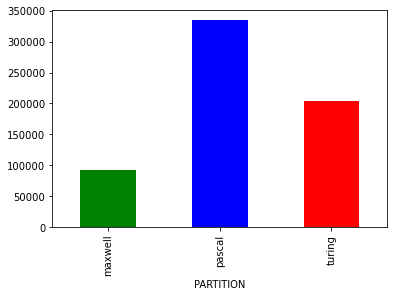

In [14]:
res.plot(kind='bar', color=['green', 'blue', "red"])

# Q5: Currently there is a 5 day limit on runtime for GPU jobs, although some users have been asking for extensions. What is the distribution of requested runtime and actual runtime on jobs on each partition? Do users really need more time, or are they simply always requesting the maximum?

In [15]:
completed_q5 = completed.copy()
completed_q5["USAGE/REQTIME"] = completed_q5["USEDTIME"] / completed_q5["REQTIME"]

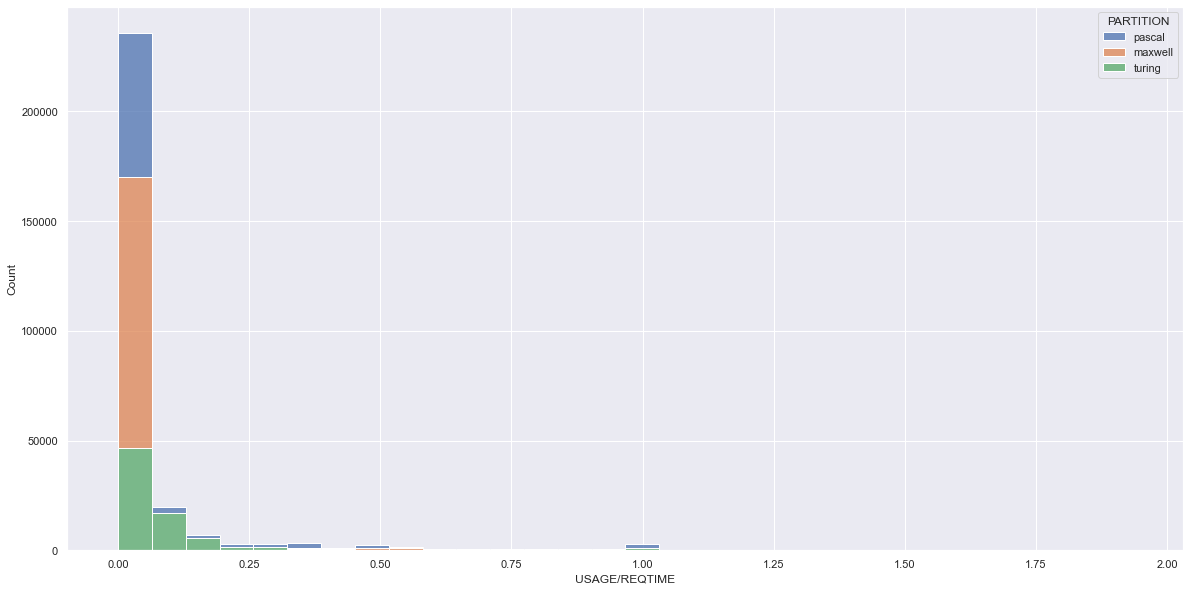

In [16]:
sns.set(rc={'figure.figsize':(20, 10)})

sns.histplot(data=completed_q5, x="USAGE/REQTIME", hue="PARTITION", multiple="stack", bins=30)
plt.show()

In [17]:
# Find how many people use <25% of their allotted time
l25 = completed_q5[completed_q5["USAGE/REQTIME"] <= 0.25].shape[0]
g25 = completed_q5[completed_q5["USAGE/REQTIME"] > 0.25].shape[0]

l25, g25, g25/(l25 + g25) * 100

(265196, 18137, 6.401301648590174)

In [18]:
(1 - 0.064) * 100

93.6

In [19]:
# Find how many people use <50% of their allotted time
l50 = completed_q5[completed_q5["USAGE/REQTIME"] <= 0.5].shape[0]
g50 = completed_q5[completed_q5["USAGE/REQTIME"] > 0.5].shape[0]

l50, g50, g50/(l50 + g50) * 100

(273746, 9587, 3.3836510395894583)

In [20]:
(1 - 0.0338) * 100

96.61999999999999

In [21]:
# Find how many people use <80% of their allotted time
l80 = completed_q5[completed_q5["USAGE/REQTIME"] <= 0.8].shape[0]
g80 = completed_q5[completed_q5["USAGE/REQTIME"] > 0.8].shape[0]

l80, g80, g80/(l80 + g80) * 100

(279098, 4235, 1.4947076408325186)

In [22]:
(1 - 0.0149) * 100

98.50999999999999

# Q5 Ans: Users tend to use a small portion of their requested time, or even no time at all.
 * 93.6% of our data is before 0.25, which suggests that an overwhelming majority of people use less than a quarter of their assigned time.
 * 96.6% of our data is before 0.5
 * 98.5% of our data is before 0.8